# Data Description

These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2023) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) useful in sorting this export's results
The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results
The date in yyyy-mm-dd format
The local time of day in hh:mm:ss 24-hour format
The numeric data, if any (may be an empty string)
The text data, if any (may be an empty string)

The units of each dataset are:

- Solar radiation: watts per meter^2
- Temperature: degrees Fahrenheit
- Humidity: percent
- Barometric pressure: Hg
- Wind direction: degrees
- Wind speed: miles per hour
- Sunrise/sunset: Hawaii time

Link: https://www.kaggle.com/datasets/dronio/SolarEnergy

# Importing Libraries



In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

!pip install xgboost
import xgboost as xgb
!pip install tensorflow
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from collections import Counter

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.5 MB/s eta 0:00:00


# Loading Data



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SolarPrediction.csv")

In [4]:
data.head(5)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


# Data Cleaning

In [6]:
df = data.copy()

In [7]:
# extract the date from the date_time format of the 'Data' parameter
df['Data'] = df['Data'].apply(lambda x : x.split()[0])

In [8]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [9]:
# extract the date time features from the given parameter using date time python methods
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [10]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


In [11]:
# extract the sunrise and sunset information using regular expression
df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['riseminuter'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [12]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Month                   32686 non-null  int32  
 12  Day                     32686 non-null  int32  
 13  Hour                    32686 non-null  int32  
 14  Minute                  32686 non-null

In [14]:
# drop the parameters that are not required after extracting the relevant information
df.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis = 1, inplace = True)

In [15]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [16]:
# check of data dimensions
df.shape

(32686, 15)

In [17]:
# checking for null values in the data
df.isnull().sum().sum()

np.int64(0)

In [18]:
input_features = df.drop('Radiation', axis = 1)
target = df['Radiation']

In [19]:
target.shape

(32686,)

# Feature Selection using Correlation Matrix

In [20]:
# extract the correlation between the data features
corr_matrix = df.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


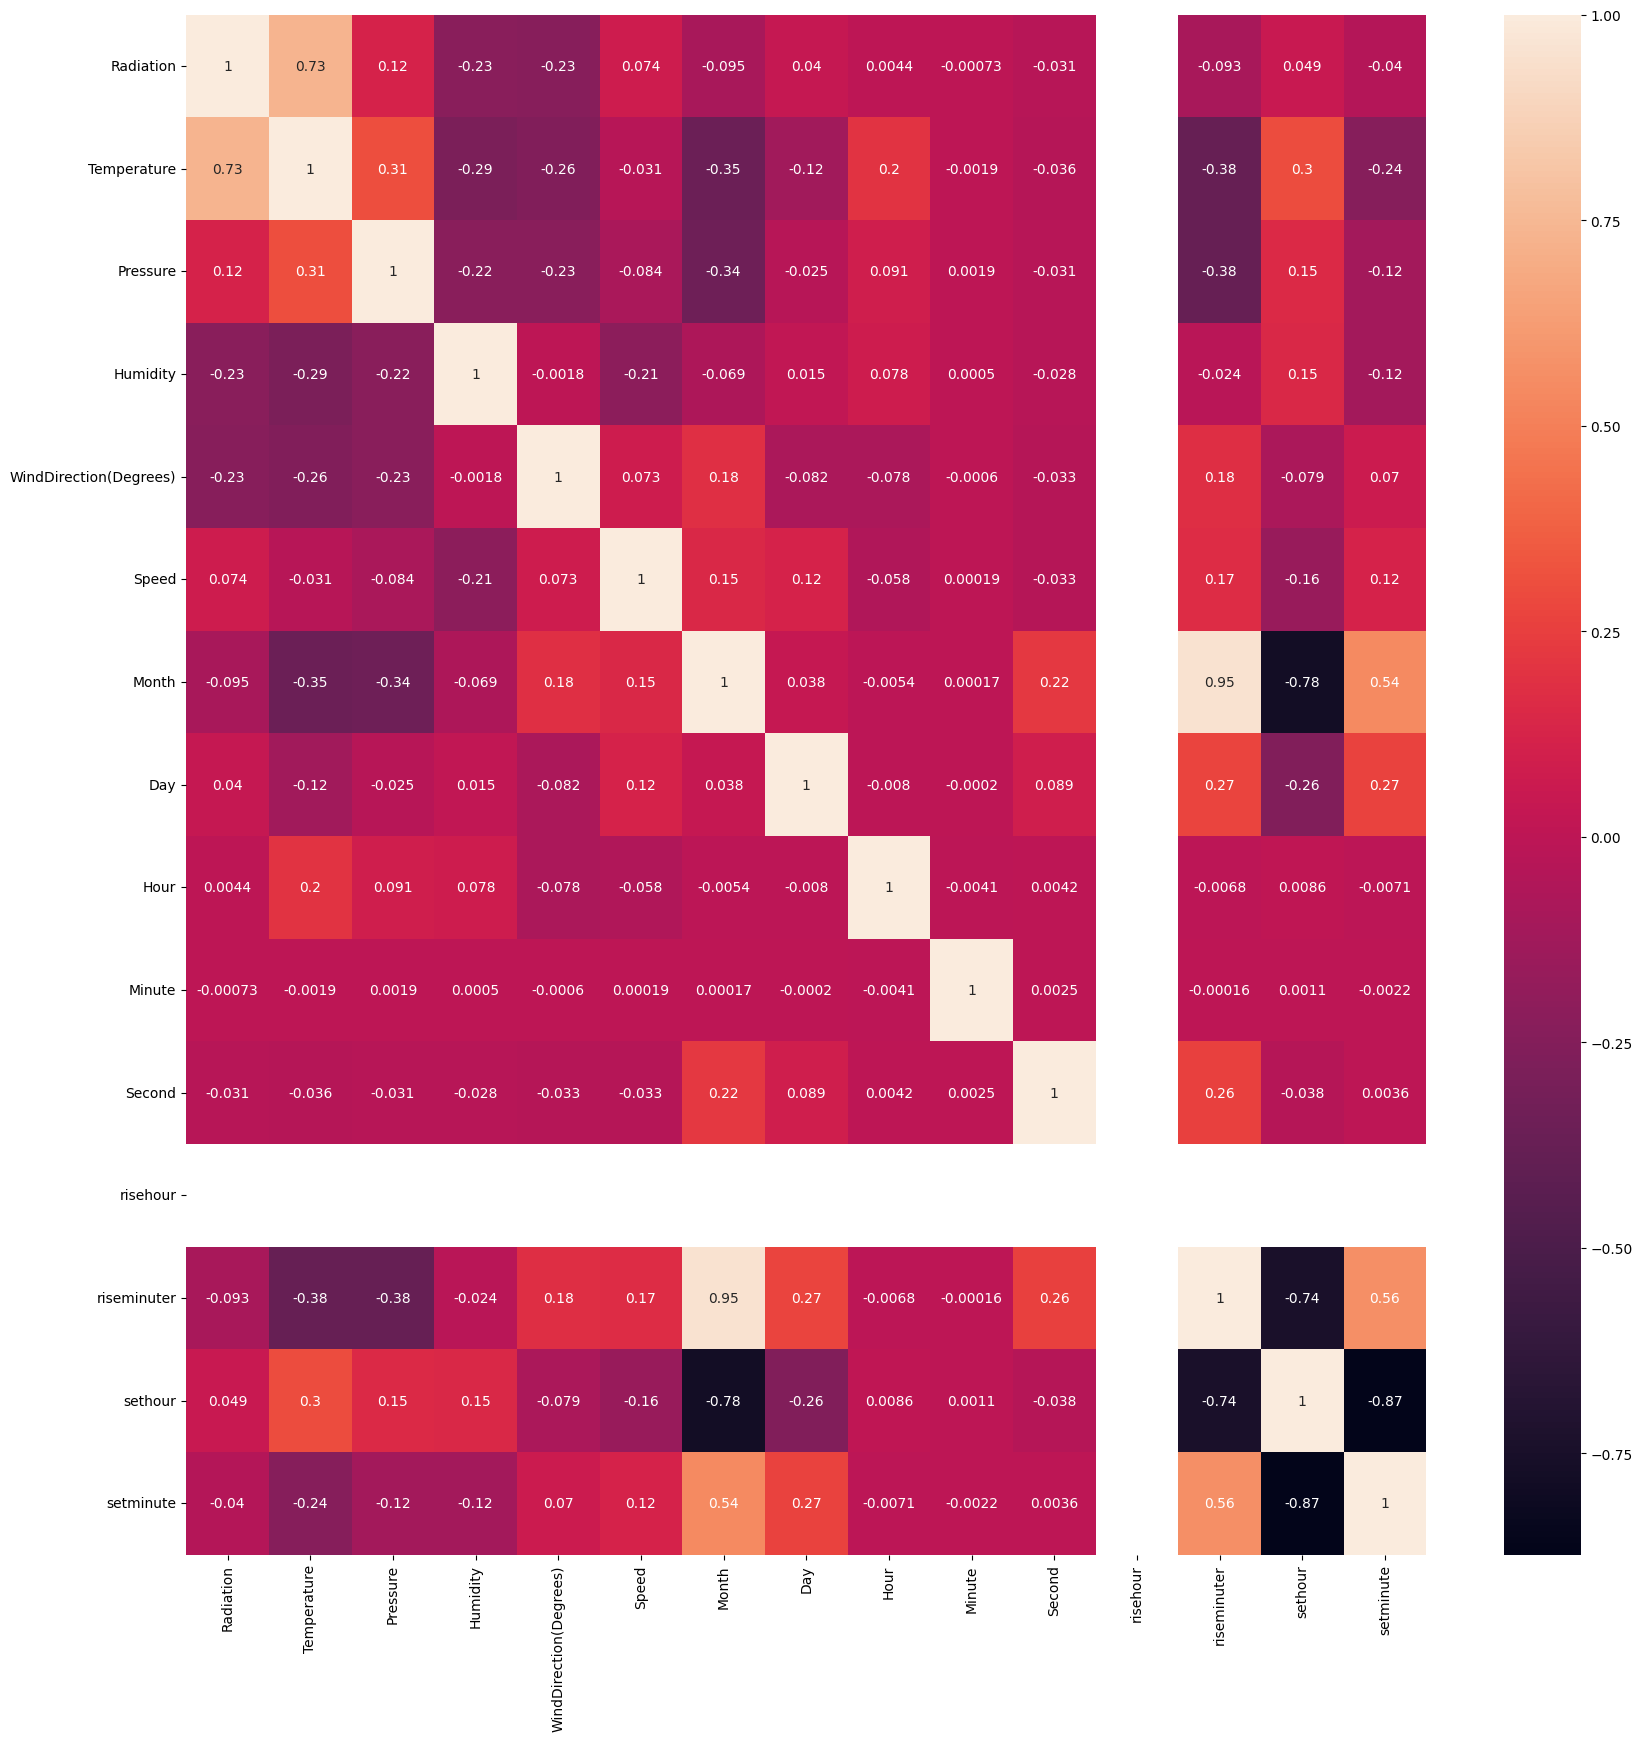

In [21]:
# plot the correlation matrix using heatmap for clear understanding
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True)
plt.show()

# Feature Selection

In [22]:
bestfeatures = SelectKBest(score_func = chi2, k = 10)

In [23]:
# use the label encoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train_Y = label_encoder.fit_transform(target)

In [24]:
target_cont = df['Radiation'].apply(lambda x : int(x*100))
scaled_input_features = MinMaxScaler().fit_transform(input_features)
fit = bestfeatures.fit(scaled_input_features, target_cont)

In [25]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)

In [26]:
# contatinating data_features with the scores
featureScores = pd.concat([column, scores], axis=1)

#naming the dataframe columns
featureScores.columns = ['Features', 'feature_imp']

In [27]:
# best features
featureScores.sort_values(by = 'feature_imp', ascending=False, inplace=True)
featureScores

,Features,feature_imp
12,sethour,12207.531454
5,Month,4684.579610
11,riseminuter,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setminute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


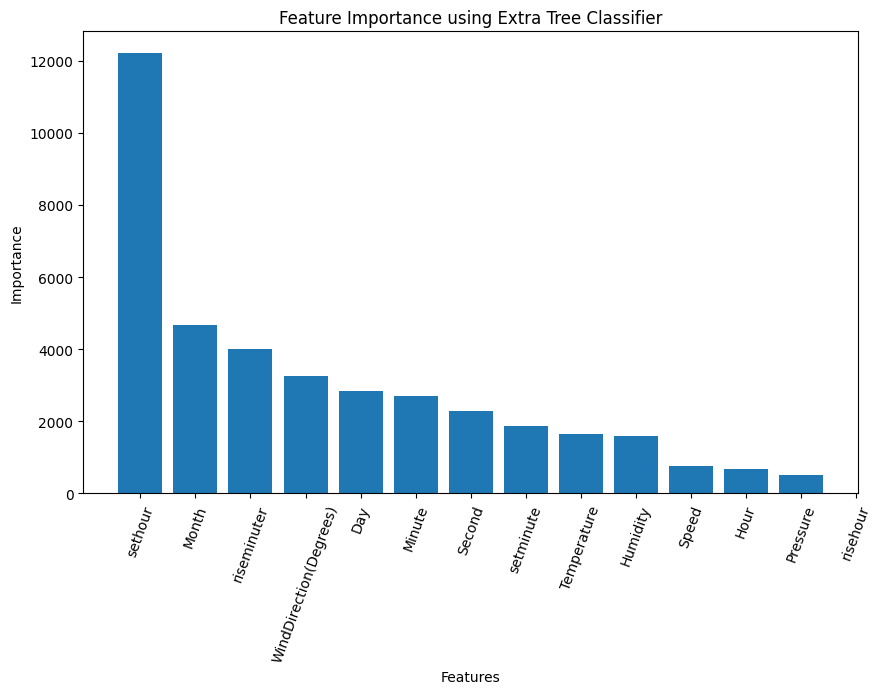

In [28]:
# visualise the feature importance
plt.figure(figsize = (10, 6))
plt.bar(featureScores.Features, featureScores.feature_imp)
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

# Data Normalization and Transformation

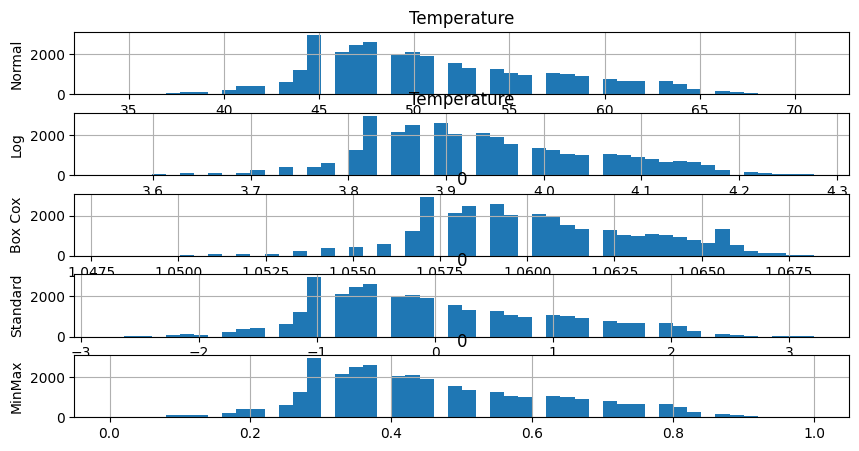

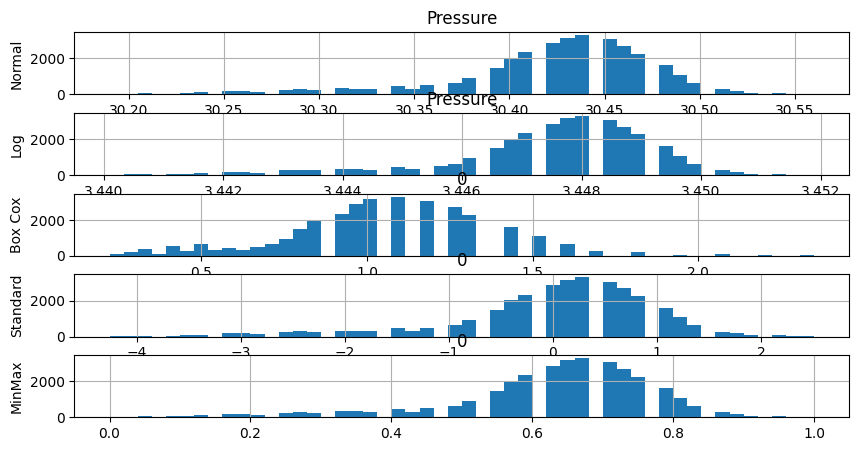

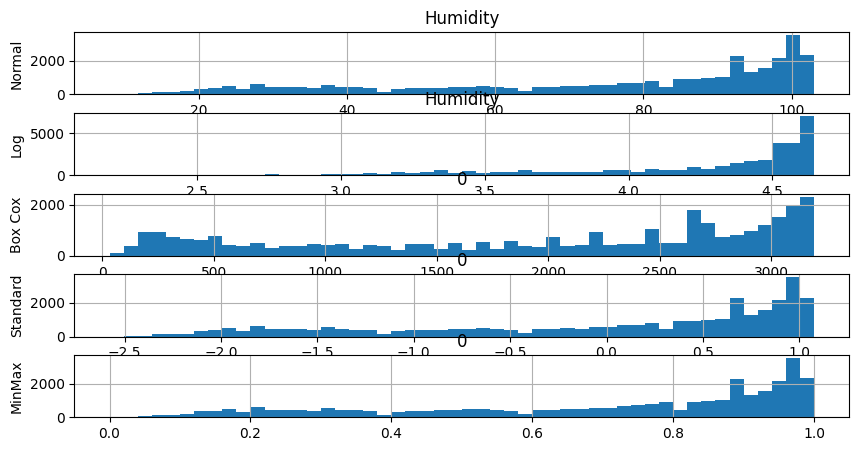

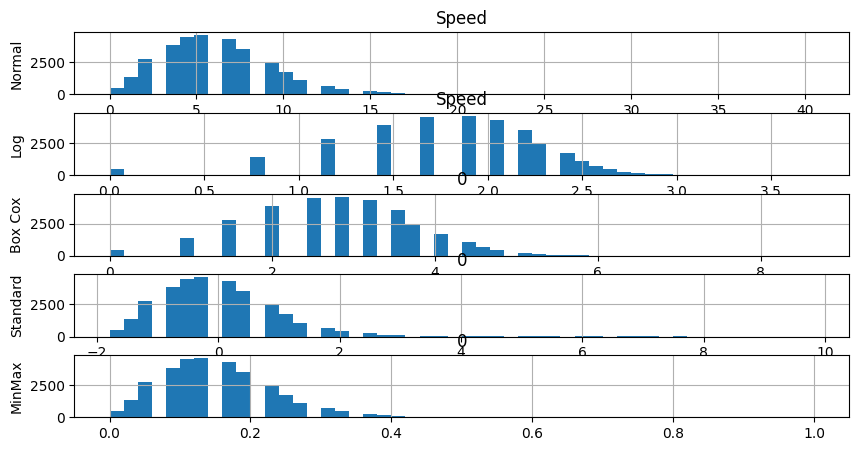

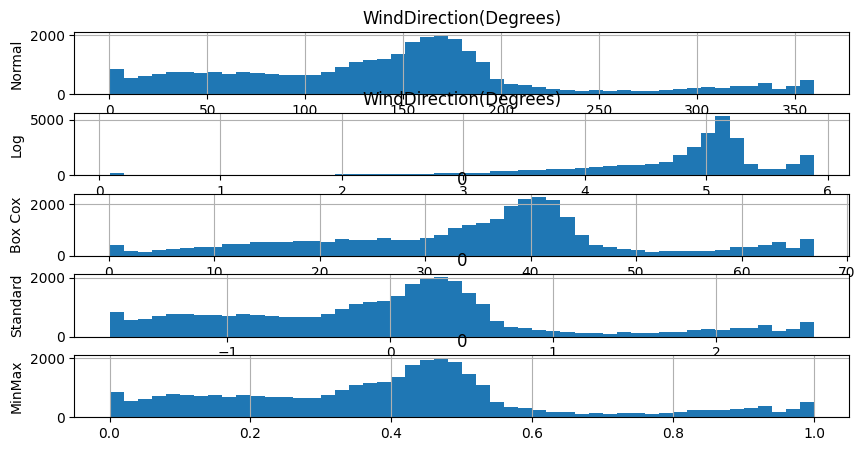

In [29]:
# Looking for transformation
features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']

for i in features_to_transform:

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 5))

    pd.DataFrame(input_features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax = ax3, bins = 50)
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)

    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')

In [30]:
# set the transformations required
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log),
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0],
            'Humidity' : stats.boxcox(input_features['Humidity']+1)[0],
            'Speed' : (input_features['Speed']+1).transform(np.log),
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]

In [31]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,3.89182,1.245832e+297,1139.358153,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,1.245832e+297,1104.046486,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,1.245832e+297,1069.253069,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,1.245832e+297,1175.186958,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,1.245832e+297,1248.391644,0.291391,1.890095,9,29,23,35,24,6,13,18,13


In [32]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [33]:
xtrain.shape, xtest.shape

((26148, 14), (6538, 14))

In [34]:
# declare parameters
params = {
    'learning_rate': 0.1,
    'max_depth': 8}

from xgboost import XGBRegressor
model = XGBRegressor(**params)

In [35]:
# train the model
model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [36]:
y_pred = model.predict(xtest)

In [37]:
print('XGBoost model result: {0:0.4f}'. format(np.sqrt(mean_squared_error(ytest, y_pred))))

XGBoost model result: 82.9945


In [38]:
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 82.99
R2: 0.93


### Probabilistic Forecasting

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KernelDensity
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [40]:
def generate_multiple_predictions(model, X_test, num_trees=None):
    """
    Generate multiple predictions from XGBoost trees.

    Parameters:
    -----------
    model : XGBRegressor
        Trained XGBoost model
    X_test : array-like
        Test features
    num_trees : int, optional
        Number of trees to use, if None all trees are used

    Returns:
    --------
    predictions : numpy.ndarray
        Array of predictions with shape (n_samples, n_trees)
    """
    # Get the number of trees in the model
    if num_trees is None:
        num_trees = model.get_booster().num_boosted_rounds()

    # Initialize array to store predictions
    n_samples = X_test.shape[0]
    predictions = np.zeros((n_samples, num_trees))

    # Get predictions from each tree
    for i in range(num_trees):
        # Predict with first i+1 trees
        pred = model.predict(X_test)
        predictions[:, i] = pred

    return predictions

In [41]:
# Function to apply KDE and get prediction intervals
def get_prediction_intervals(predictions, confidence_levels=[0.80, 0.85, 0.90]):
    """
    Apply KDE to get prediction intervals at different confidence levels.

    Parameters:
    -----------
    predictions : numpy.ndarray
        Array of predictions with shape (n_samples, n_trees)
    confidence_levels : list, optional
        List of confidence levels (default: [0.80, 0.85, 0.90])

    Returns:
    --------
    intervals : dict
        Dictionary with keys as confidence levels and values as lists of (lower, upper) bounds
    """
    n_samples = predictions.shape[0]
    intervals = {level: [] for level in confidence_levels}

    # For each sample
    for i in range(n_samples):
        sample_preds = predictions[i, :]

        # Apply KDE
        kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(sample_preds.reshape(-1, 1))

        # Generate points to evaluate the KDE
        x_grid = np.linspace(min(sample_preds) - 50, max(sample_preds) + 50, 1000).reshape(-1, 1)

        # Compute log density
        log_density = kde.score_samples(x_grid)

        # Convert to density
        density = np.exp(log_density)

        # Normalize density to get a proper PDF
        density = density / np.sum(density)

        # Compute CDF
        cdf = np.cumsum(density)

        # For each confidence level, find the prediction interval
        for level in confidence_levels:
            alpha = (1 - level) / 2
            lower_idx = np.where(cdf >= alpha)[0][0]
            upper_idx = np.where(cdf >= 1 - alpha)[0][0]

            intervals[level].append((float(x_grid[lower_idx]), float(x_grid[upper_idx])))

    return intervals

In [42]:
# Function to evaluate prediction intervals
def evaluate_prediction_intervals(intervals, y_true):
    """
    Evaluate prediction intervals.

    Parameters:
    -----------
    intervals : dict
        Dictionary with keys as confidence levels and values as lists of (lower, upper) bounds
    y_true : array-like
        True values

    Returns:
    --------
    metrics : dict
        Dictionary with metrics (PICP, PINAW, CWC) for each confidence level
    """
    metrics = {}

    for level, bounds in intervals.items():
        # Extract lower and upper bounds
        lower_bounds = np.array([bound[0] for bound in bounds])
        upper_bounds = np.array([bound[1] for bound in bounds])

        # Calculate PICP (Prediction Interval Coverage Probability)
        covered = np.logical_and(y_true >= lower_bounds, y_true <= upper_bounds)
        picp = np.mean(covered) * 100

        # Calculate PINAW (Prediction Interval Normalized Average Width)
        width = upper_bounds - lower_bounds
        range_value = np.max(y_true) - np.min(y_true)
        pinaw = np.mean(width) / range_value * 100

        # Calculate CWC (Coverage Width-based Criterion)
        mu = level * 100  # Expected coverage
        eta = 50  # Penalty factor
        gamma = 0 if picp >= mu else 1
        cwc = pinaw * (1 + gamma * np.exp(-eta * (picp - mu) / 100))

        metrics[level] = {
            'PICP': picp,
            'PINAW': pinaw,
            'CWC': cwc
        }

    return metrics


In [43]:
# Function to visualize prediction intervals
def plot_prediction_intervals(dates, y_true, y_pred, intervals, confidence_levels=[0.80, 0.85, 0.90],
                             title='Solar Irradiance Prediction with Confidence Intervals'):
    """
    Visualize prediction intervals.

    Parameters:
    -----------
    dates : array-like
        Dates or timestamps for x-axis
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    intervals : dict
        Dictionary with keys as confidence levels and values as lists of (lower, upper) bounds
    confidence_levels : list, optional
        List of confidence levels (default: [0.80, 0.85, 0.90])
    title : str, optional
        Plot title
    """
    plt.figure(figsize=(14, 8))

    # Plot true values
    plt.plot(dates, y_true, 'k.-', label='Measured Irradiance', linewidth=1.5)

    # Plot predictions
    plt.plot(dates, y_pred, 'r.-', label='Predicted Irradiance', linewidth=1.5)

    # Define colors for different confidence levels
    colors = ['#add8e6', '#90c8e0', '#70b8da']

    # Plot intervals for each confidence level
    for i, level in enumerate(sorted(confidence_levels)):
        lower_bounds = np.array([bound[0] for bound in intervals[level]])
        upper_bounds = np.array([bound[1] for bound in intervals[level]])

        plt.fill_between(dates, lower_bounds, upper_bounds,
                         color=colors[i], alpha=0.3,
                         label=f'{int(level*100)}% Confidence Interval')

    # Format x-axis if dates are datetime objects
    if isinstance(dates[0], pd.Timestamp) or isinstance(dates[0], np.datetime64):
        plt.gca().xaxis.set_major_formatter(DateFormatter('%b %d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.gcf().autofmt_xdate()

    # Add labels and legend
    plt.xlabel('Time')
    plt.ylabel('Solar Irradiance (W/m²)')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

    # Show plot
    plt.tight_layout()
    plt.show()

In [44]:
# Main function to implement the entire workflow
def xgboost_kde_forecasting(X_train, y_train, X_test, y_test, params=None, confidence_levels=[0.80, 0.85, 0.90], dates=None):
    """
    Implement the XGBoost-KDE probabilistic forecasting workflow.

    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training target
    X_test : array-like
        Test features
    y_test : array-like
        Test target
    params : dict, optional
        XGBoost parameters
    confidence_levels : list, optional
        List of confidence levels (default: [0.80, 0.85, 0.90])
    dates : array-like, optional
        Dates for plotting

    Returns:
    --------
    results : dict
        Dictionary with results and metrics
    """
    # Set default parameters if not provided
    if params is None:
        params = {
            'learning_rate': 0.1,
            'max_depth': 8,
            'n_estimators': 100,
            'objective': 'reg:squarederror'
        }

    # Create and train XGBoost model
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Generate point predictions
    y_pred = model.predict(X_test)

    # Calculate deterministic metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"Deterministic Metrics:")
    print(f"MAE: {mae:.2f} W/m²")
    print(f"RMSE: {rmse:.2f} W/m²")

    # Generate multiple predictions from XGBoost trees
    multiple_preds = generate_multiple_predictions(model, X_test)

    # Get prediction intervals using KDE
    intervals = get_prediction_intervals(multiple_preds, confidence_levels)

    # Evaluate prediction intervals
    metrics = evaluate_prediction_intervals(intervals, y_test)

    print("\nProbabilistic Metrics:")
    for level, metric in metrics.items():
        print(f"Confidence Level: {int(level*100)}%")
        print(f"  PICP: {metric['PICP']:.2f}%")
        print(f"  PINAW: {metric['PINAW']:.2f}%")
        print(f"  CWC: {metric['CWC']:.4f}")

    # Plot results if dates are provided
    if dates is not None:
        plot_prediction_intervals(dates, y_test, y_pred, intervals, confidence_levels)

    # Return results
    results = {
        'model': model,
        'y_pred': y_pred,
        'multiple_preds': multiple_preds,
        'intervals': intervals,
        'metrics': {
            'deterministic': {
                'MAE': mae,
                'RMSE': rmse
            },
            'probabilistic': metrics
        }
    }

    return results

In [45]:
params = {
    'learning_rate': 0.1,
    'max_depth': 8,
    'n_estimators': 100,
    'objective': 'reg:squarederror'
}

In [46]:
results = xgboost_kde_forecasting(
    xtrain,
    ytrain,
    xtest,
    ytest,
    params=params,
    confidence_levels=[0.80, 0.85, 0.90]
)

Deterministic Metrics:
MAE: 33.19 W/m²
RMSE: 82.99 W/m²

Probabilistic Metrics:
Confidence Level: 80%
  PICP: 3.49%
  PINAW: 0.02%
  CWC: 877104549511731.2500
Confidence Level: 85%
  PICP: 3.49%
  PINAW: 0.02%
  CWC: 10685320877332206.0000
Confidence Level: 90%
  PICP: 3.49%
  PINAW: 0.02%
  CWC: 130173857056278352.0000


In [47]:
model = results['model']
y_pred = results['y_pred']
intervals = results['intervals']
metrics = results['metrics']

In [48]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [49]:
y_pred

array([  2.9705415,   0.8676073, 248.4011   , ...,   1.6999291,
         2.4823623,   1.7124765], dtype=float32)

In [50]:
intervals

{0.8: [(2.8203913270532226, 3.120691627353523),
  (0.7174571453630065, 1.0177574456633067),
  (248.25094237914672, 248.55124267944703),
  (3.7805275022088622, 4.080827802509162),
  (2.7845679818688964, 3.0848682821691966),
  (2.527136951595459, 2.827437251895759),
  (1.602952152401123, 1.9032524527014232),
  (2.5315004884301757, 2.831800788730476),
  (0.12841260424247736, 0.42871290454277755),
  (582.9697228967249, 583.2700231970251),
  (-2.5820845068395997, -2.2817842065392995),
  (14.728825718074951, 15.029126018375251),
  (1.2043165265618896, 1.5046168268621898),
  (0.35086181750885004, 0.6511621178091502),
  (1.2953592835961913, 1.5956595838964915),
  (852.9680139123499, 853.2683142126501),
  (1.6029068528710937, 1.9032071531713939),
  (197.7537194787561, 198.0540197790564),
  (118.81783691039672, 119.11813721069703),
  (71.5498620568811, 71.8501623571814),
  (1.4051190911828613, 1.7054193914831615),
  (965.1454431115686, 965.4457434118689),
  (2.9472736417352294, 3.247573942035529

In [51]:
metrics

{'deterministic': {'MAE': 33.19479850289494,
  'RMSE': np.float64(82.99447188040851)},
 'probabilistic': {0.8: {'PICP': np.float64(3.487304986234322),
   'PINAW': np.float64(0.021307413972220756),
   'CWC': np.float64(877104549511731.2)},
  0.85: {'PICP': np.float64(3.487304986234322),
   'PINAW': np.float64(0.021307413972220756),
   'CWC': np.float64(1.0685320877332206e+16)},
  0.9: {'PICP': np.float64(3.487304986234322),
   'PINAW': np.float64(0.021307413972220756),
   'CWC': np.float64(1.3017385705627835e+17)}}}

In [52]:
feature_names = ['month', 'day_of_year', 'hour', 'temperature', 'humidity',
                 'cloud_cover', 'dew_point', 'wind_speed']

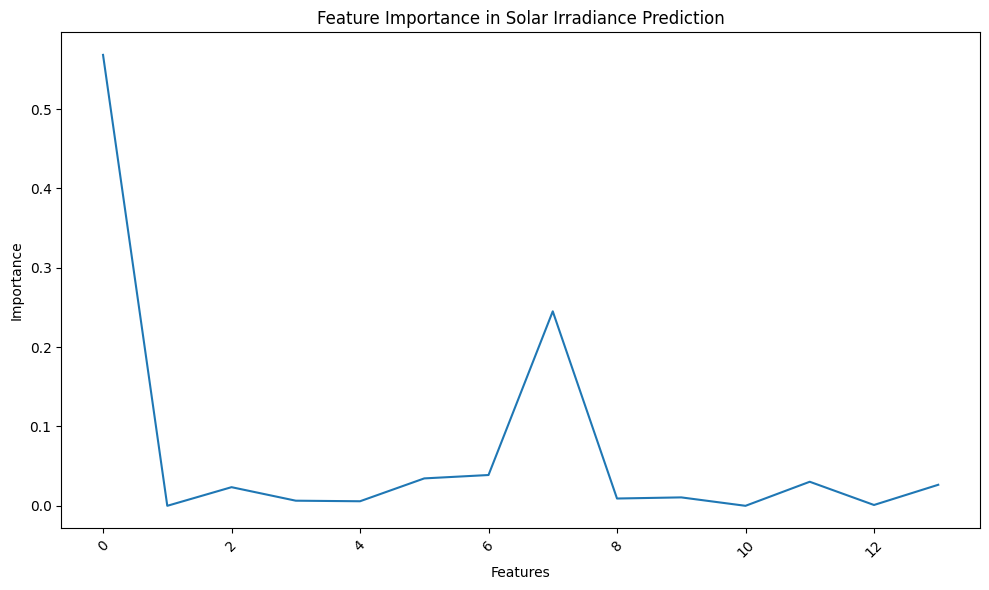

In [53]:
# Demonstrate feature importance
model = results['model']
plt.figure(figsize=(10, 6))
plt.plot(model.feature_importances_)
plt.title('Feature Importance in Solar Irradiance Prediction')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [54]:
# Create date range for 3 days of hourly data (8:00-18:00)
dates = []
for day in range(1, 4):
    for hour in range(8, 19):
        dates.append(pd.Timestamp(f'2015-03-0{day} {hour}:00:00'))
dates = pd.DatetimeIndex(dates)

# Generate some realistic solar irradiance data with day/night patterns
hours = np.array([(d.hour - 8) for d in dates])
days = np.array([d.day for d in dates])
base_irradiance = 500 * np.sin(np.pi * hours / 10)  # Peak at midday
actual_irradiance = base_irradiance * (0.7 + 0.3 * np.sin(days))  # Vary by day
actual_irradiance += np.random.normal(0, 50, len(dates))  # Add noise

# Generate predicted values and some variation
predicted_irradiance = actual_irradiance * 0.9 + np.random.normal(20, 30, len(dates))
predicted_irradiance = np.maximum(predicted_irradiance, 0)  # No negative irradiance

# For KDE visualization, let's use a single time point's predictions
# In reality, these would be the multiple predictions from XGBoost trees
sample_time_idx = 10  # Mid-day sample
multiple_predictions = predicted_irradiance[sample_time_idx] + np.random.normal(0, 40, 100)

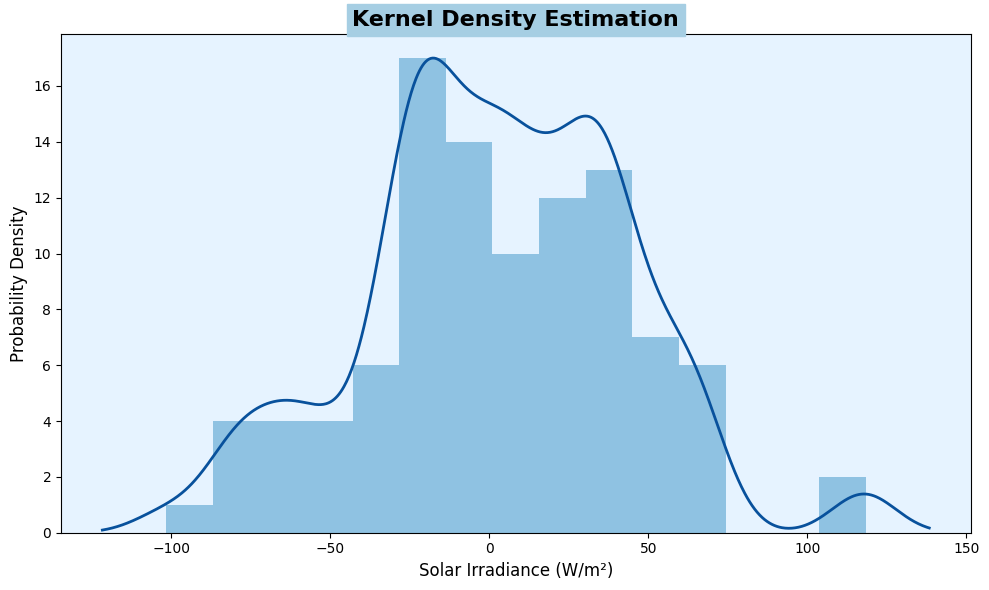

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#e6f3ff')  # Light blue background like in the paper

# Create histogram
counts, bins, _ = plt.hist(multiple_predictions, bins=15, alpha=0.7, color='#6baed6')

# Calculate KDE
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(multiple_predictions.reshape(-1, 1))
x_grid = np.linspace(min(multiple_predictions) - 20, max(multiple_predictions) + 20, 1000).reshape(-1, 1)
log_density = kde.score_samples(x_grid)
density = np.exp(log_density)

# Scale density to match histogram height
density_scaled = density * (max(counts) / max(density))

# Plot KDE curve
plt.plot(x_grid, density_scaled, color='#08519c', linewidth=2)

plt.title('Kernel Density Estimation', fontsize=16, fontweight='bold', backgroundcolor='#a6cee3')
plt.xlabel('Solar Irradiance (W/m²)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.tight_layout()
plt.savefig('kde_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

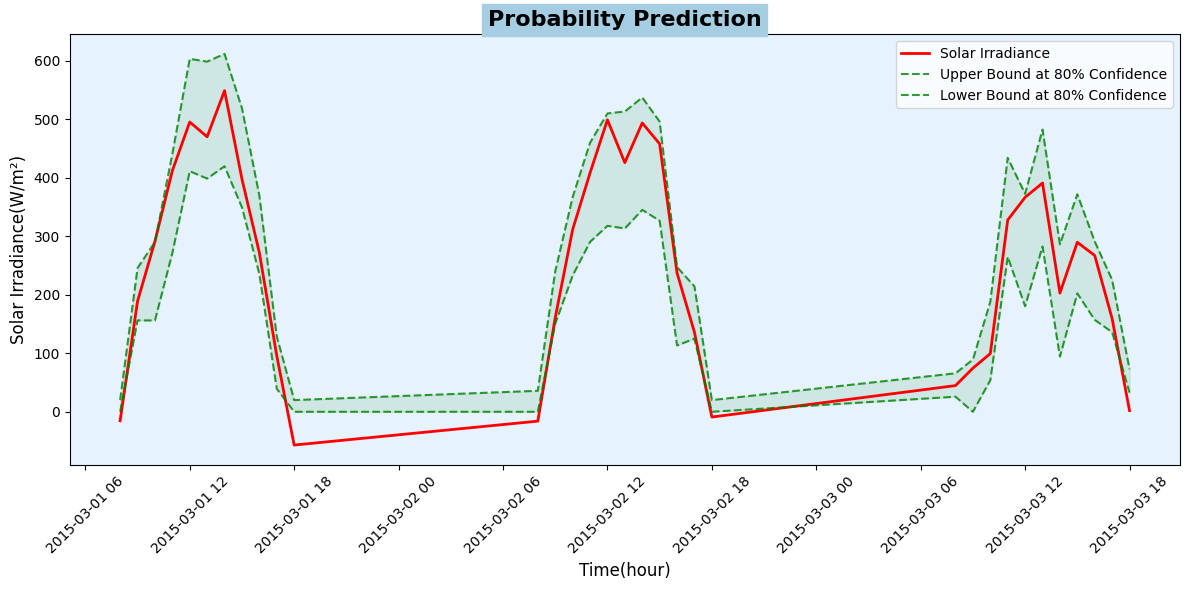

In [56]:
# Calculate prediction intervals for each time point
lower_bound = []
upper_bound = []

# Generate intervals (in practice, these would come from your KDE analysis)
for i in range(len(dates)):
    spread = 80 * np.sin(np.pi * hours[i] / 10) + 20  # Wider intervals at peak solar hours
    lower_bound.append(max(0, predicted_irradiance[i] - spread))
    upper_bound.append(predicted_irradiance[i] + spread)

# Create the probability prediction plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_facecolor('#e6f3ff')  # Light blue background

# Plot actual irradiance
plt.plot(dates, actual_irradiance, 'r-', label='Solar Irradiance', linewidth=2)

# Plot upper and lower bounds
plt.plot(dates, upper_bound, 'g--', label='Upper Bound at 80% Confidence', linewidth=1.5, alpha=0.8)
plt.plot(dates, lower_bound, 'g--', label='Lower Bound at 80% Confidence', linewidth=1.5, alpha=0.8)

# Fill between the bounds
plt.fill_between(dates, lower_bound, upper_bound, color='g', alpha=0.1)

# Format x-axis to show dates
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H'))
plt.xticks(rotation=45)

# Set labels and title
plt.title('Probability Prediction', fontsize=16, fontweight='bold', backgroundcolor='#a6cee3')
plt.xlabel('Time(hour)', fontsize=12)
plt.ylabel('Solar Irradiance(W/m²)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('probability_prediction.png', dpi=300, bbox_inches='tight')
plt.show()
